# Belgium Ancient Book 1601-1625 data analysis and visualization

## descriptive statistics

The LIMO database of ancient books contains information about printed publications present at the Library of Leuven which can be dated before 1840. Our specific dataset contains the metadata from ancient Belgian books dating from 1601 to 1625. The metadata is organized into two main categories. First, there is the bibliographical information of the books, for example their (sub)title, author(s), publisher(s), seller(s), printer(s) and so on. Second, there is the holding information of the books, including their provenance, acquisition, library, and physical location. 

In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from PIL import Image
from nltk.corpus import stopwords

import folium
from folium import plugins


import gender_guesser.detector

from collections import defaultdict
import re
import networkx as nx
import itertools
from pyvis.network import Network
import community as community_louvain

The first part of the exploration is to take a look at the demographic characterists of the authors using the reconciled data

In [308]:
## Since the author names in column 700 are separated into two columns 700$0$0$a and 700$1$0$a in our previous data cleaning, 
# Here I add the reconciled values seprately and join the two dataframe together to get 
df_7000a = pd.read_csv('7000a.csv',encoding = 'latin1')
df_7001a = pd.read_csv('7001a.csv',encoding = 'latin1')
df_reconcile=df_7000a.append(df_7001a)

C:\Users\95327\AppData\Local\Temp\ipykernel_85392\2051073032.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_reconcile=df_7000a.append(df_7001a)


In [332]:
df_reconcile['bool']=None

In [336]:
# To see whether the authors have been reconciled. 
# If both the name and identifier are NaN, it means there are several reconciled value for the same person
# If the name is not NaN and the identifier is NaN, it means the name has not been reconciled.
#If they are not reconciled, they will be dropped from the table later.
df_reconcile['bool']=df_reconcile['author name'].isna() ^df_reconcile['identifier'].isna()

In [337]:
df_reconcile

,author name,identifier,country of citizenship,educated at,field of work,occupation,religion or worldview,sex or gender,bool
0,"Albert VII, Archduke of Austria",Q311452,Archduchy of Austria,NaN,NaN,military personnel,Catholic Church,male,False
1,NaN,NaN,NaN,NaN,NaN,Catholic priest,NaN,NaN,False
2,Isabella Clara Eugenia,Q158256,Spain,NaN,NaN,politician,Catholic Church,female,False
3,Alonso de Madrid,Q5670348,Spain,NaN,NaN,literary,Catholicism,male,False
4,Aegidius Aureaevalensis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...
4289,Diego de Estella,Q325647,Spain,University of Toulouse,NaN,theologian,Catholic Church,male,False
4290,NaN,NaN,NaN,University of Salamanca,NaN,monk,NaN,NaN,False
4291,Jan van Blitterswyck,Q27995644,NaN,NaN,NaN,monk,NaN,male,False
4292,"Van Blitterswyck, Maria",NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [338]:
df_reconcile_clean = df_reconcile.loc[df_reconcile['bool']==False]

In [339]:
df_reconcile_clean

,author name,identifier,country of citizenship,educated at,field of work,occupation,religion or worldview,sex or gender,bool
0,"Albert VII, Archduke of Austria",Q311452,Archduchy of Austria,NaN,NaN,military personnel,Catholic Church,male,False
1,NaN,NaN,NaN,NaN,NaN,Catholic priest,NaN,NaN,False
2,Isabella Clara Eugenia,Q158256,Spain,NaN,NaN,politician,Catholic Church,female,False
3,Alonso de Madrid,Q5670348,Spain,NaN,NaN,literary,Catholicism,male,False
6,Bernard of Clairvaux,Q188411,France,NaN,philosophy,theologian,Catholic Church,male,False
...,...,...,...,...,...,...,...,...,...
4288,Cornelius Thielmans,Q64031624,NaN,NaN,NaN,writer,NaN,male,False
4289,Diego de Estella,Q325647,Spain,University of Toulouse,NaN,theologian,Catholic Church,male,False
4290,NaN,NaN,NaN,University of Salamanca,NaN,monk,NaN,NaN,False
4291,Jan van Blitterswyck,Q27995644,NaN,NaN,NaN,monk,NaN,male,False


In [314]:
df_reconcile_clean['author name'].fillna(method='ffill',inplace=True)
df_reconcile_clean['identifier'].fillna(method='ffill',inplace=True)

C:\Users\95327\AppData\Local\Temp\ipykernel_85392\3777763541.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reconcile_clean['author name'].fillna(method='ffill',inplace=True)
C:\Users\95327\AppData\Local\Temp\ipykernel_85392\3777763541.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reconcile_clean['identifier'].fillna(method='ffill',inplace=True)


In [315]:
df_reconcile_clean

,author name,identifier,country of citizenship,educated at,field of work,occupation,religion or worldview,sex or gender,bool
0,"Albert VII, Archduke of Austria",Q311452,Archduchy of Austria,NaN,NaN,military personnel,Catholic Church,male,False
1,"Albert VII, Archduke of Austria",Q311452,NaN,NaN,NaN,Catholic priest,NaN,NaN,False
2,Isabella Clara Eugenia,Q158256,Spain,NaN,NaN,politician,Catholic Church,female,False
3,Alonso de Madrid,Q5670348,Spain,NaN,NaN,literary,Catholicism,male,False
6,Bernard of Clairvaux,Q188411,France,NaN,philosophy,theologian,Catholic Church,male,False
...,...,...,...,...,...,...,...,...,...
4288,Cornelius Thielmans,Q64031624,NaN,NaN,NaN,writer,NaN,male,False
4289,Diego de Estella,Q325647,Spain,University of Toulouse,NaN,theologian,Catholic Church,male,False
4290,Diego de Estella,Q325647,NaN,University of Salamanca,NaN,monk,NaN,NaN,False
4291,Jan van Blitterswyck,Q27995644,NaN,NaN,NaN,monk,NaN,male,False


In [316]:
df_unique = df_reconcile_clean.drop_duplicates(subset=['identifier'],keep='first')

Now we can use the unique dataframe to analysis the authors' gender,religion, citizenship since these values are unique
and use cleaned data to analyze the education, occupation and field of work the because they have multiple value

## Gender

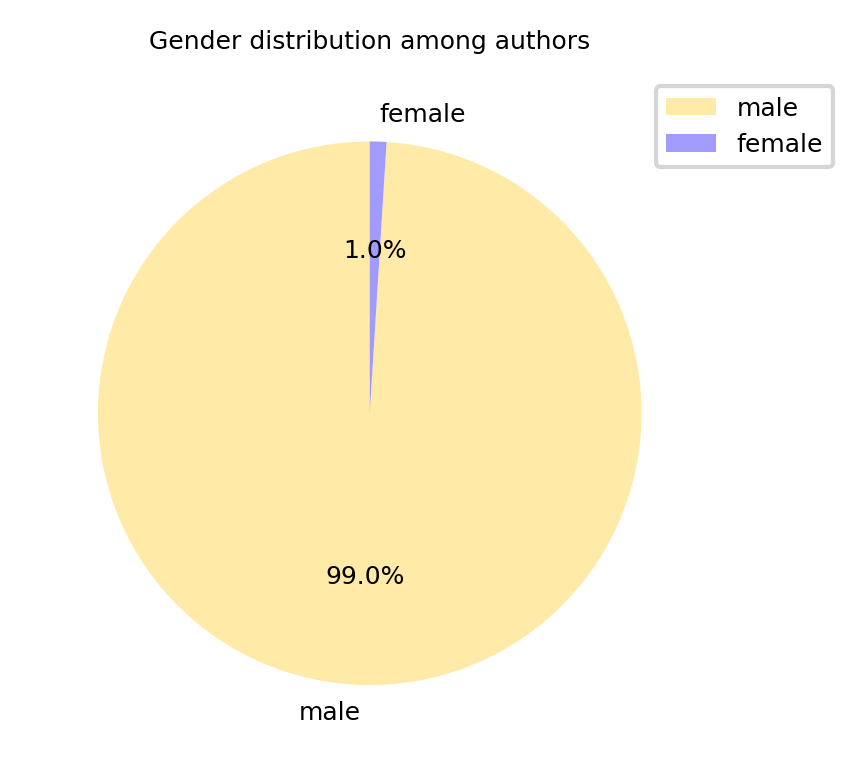

In [317]:
df_gender= df_unique.dropna(subset=['sex or gender'])

sum_male=sum(df_gender['sex or gender']=='male')
sum_female=sum(df_gender['sex or gender']=='female')
category_names=['male','female']
sizes=[sum_male,sum_female]
plt.figure(figsize=(3,3),dpi=300)
custom_colors=['#ffeaa7','#a29bfe']
plt.pie(sizes,labels=category_names,textprops={'fontsize':6},startangle=90,colors=custom_colors,autopct='%1.1f%%')
plt.title("Gender distribution among authors",fontsize=6) 
plt.legend(bbox_to_anchor=(1.2, 1),fontsize=6)
plt.show()

## Religion

In [319]:
df_religion= df_unique.dropna(subset=['religion or worldview'])
df_religion['religion or worldview'].value_counts()

Catholic Church            139
Catholicism                 43
Protestantism                5
Eastern Orthodoxy            3
Calvinism                    2
Eastern Christianity         1
Eastern Orthodox Church      1
Christianity                 1
Christian                    1
Greco-Roman religion         1
Name: religion or worldview, dtype: int64

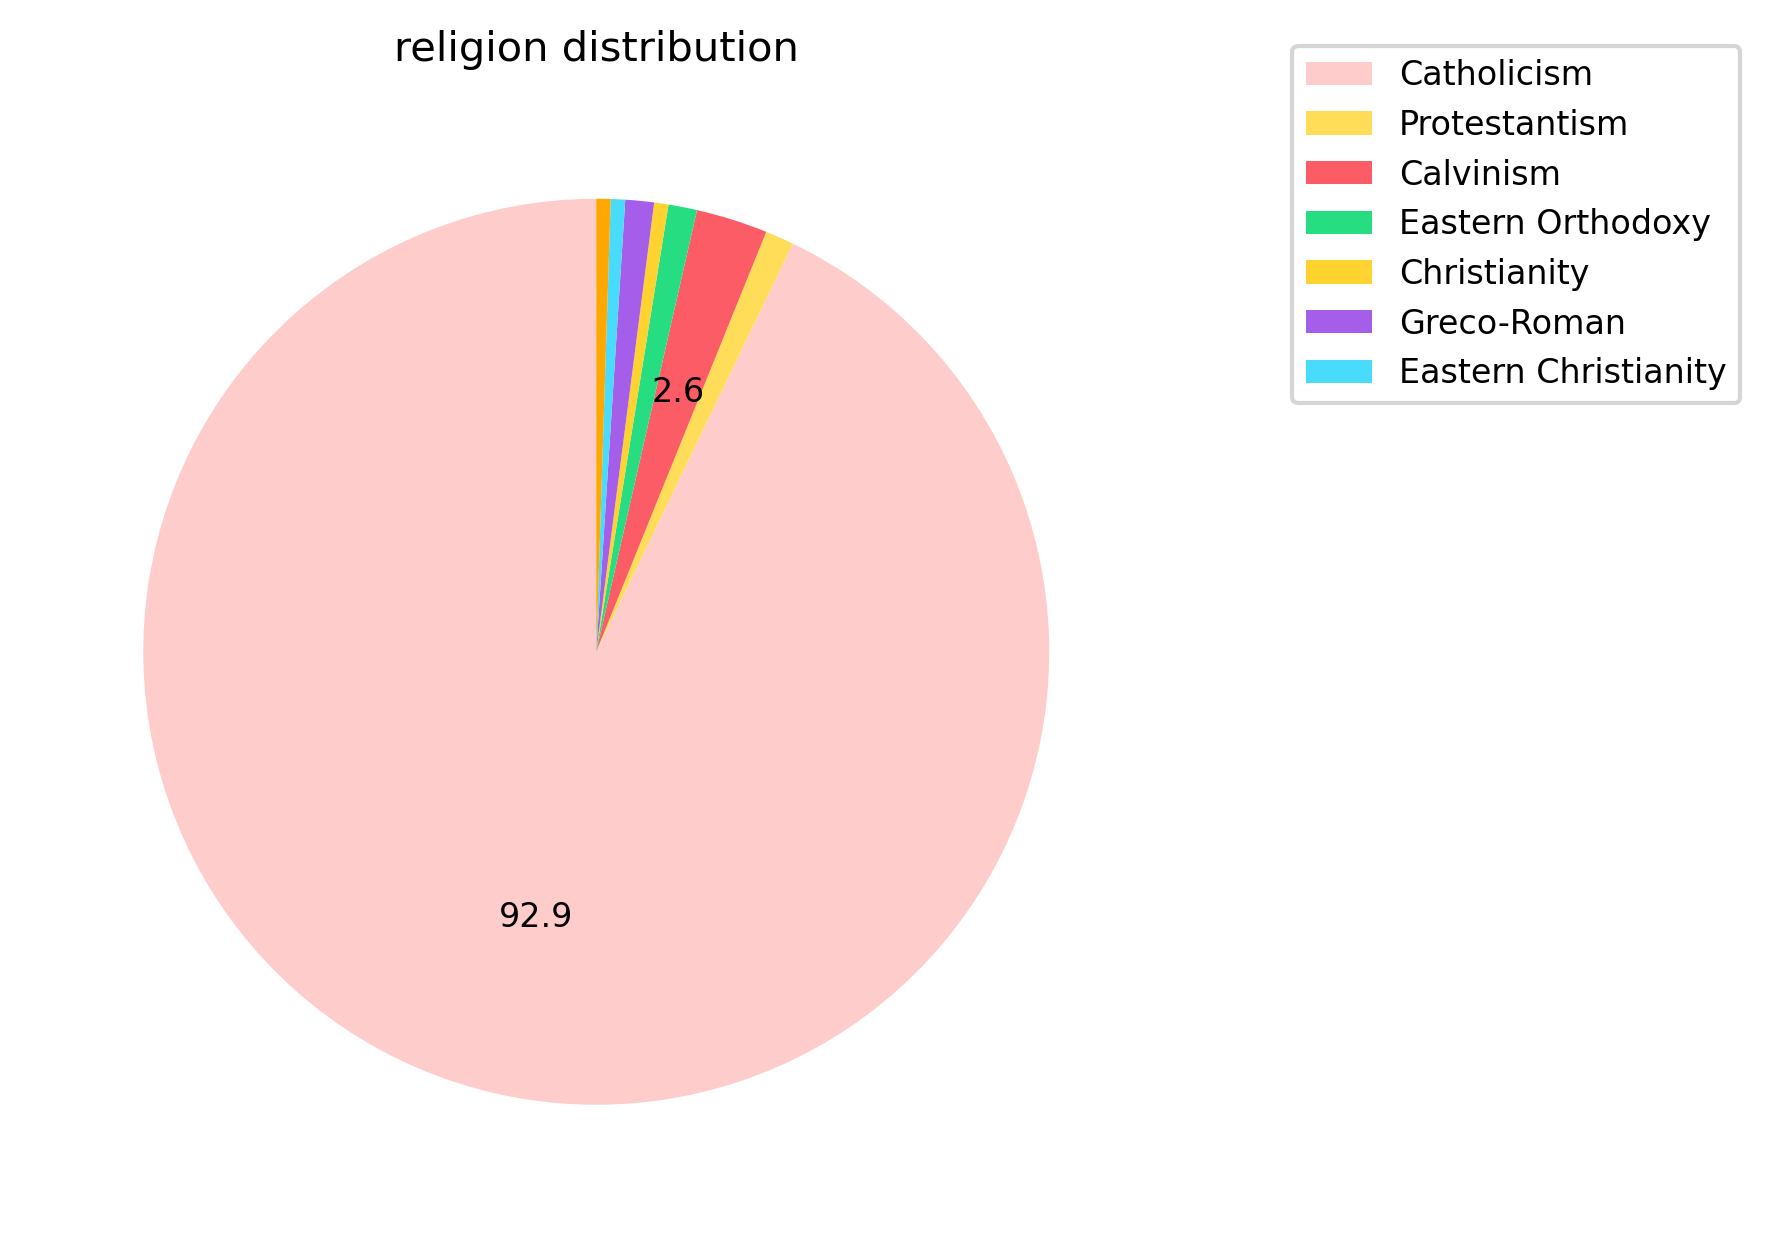

In [345]:
sum_Catholicism=sum(df_religion['religion or worldview'].isin(['Catholic Church','Catholicism']))
sum_Protestantism=sum(df_religion['religion or worldview']=='Protestantism')
sum_Calvinism=sum(df_religion['religion or worldview']=='Calvinism')
sum_Eastern_Orthodoxy=sum(df_religion['religion or worldview'].isin(['Eastern Orthodoxy ','Eastern Orthodox Church']))
sum_Christianity =sum(df_religion['religion or worldview'].isin(['Christianity','Christian']))
sum_Greco_Roman=sum(df_religion['religion or worldview']=='Greco-Roman religion')
sum_Eastern_Christianity=sum(df_religion['religion or worldview']=='Eastern Christianity')

category_names=['Catholicism','Protestantism','Calvinism','Eastern Orthodoxy','Christianity','Greco-Roman','Eastern Christianity']
sizes=[sum_Catholicism,sum_Christianity,sum_Protestantism,sum_Calvinism,sum_Eastern_Orthodoxy,sum_Calvinism,sum_Greco_Roman,sum_Eastern_Christianity]
plt.figure(figsize=(5,5),dpi=300)
custom_colors=['#ffcccc','#ffdd59','#fc5c65','#26de81','#fed330','#a55eea','#48dbfb','#ffa801']
    
plt.pie(sizes,textprops={'fontsize':8},startangle=90,colors=custom_colors,autopct = lambda p: format(p, '.1f') if p > 2 else None)
plt.legend(bbox_to_anchor=(1.1,1.05),fontsize=8,labels=category_names)
plt.title("religion distribution",fontsize=10) 
plt.show()

## Citizenship

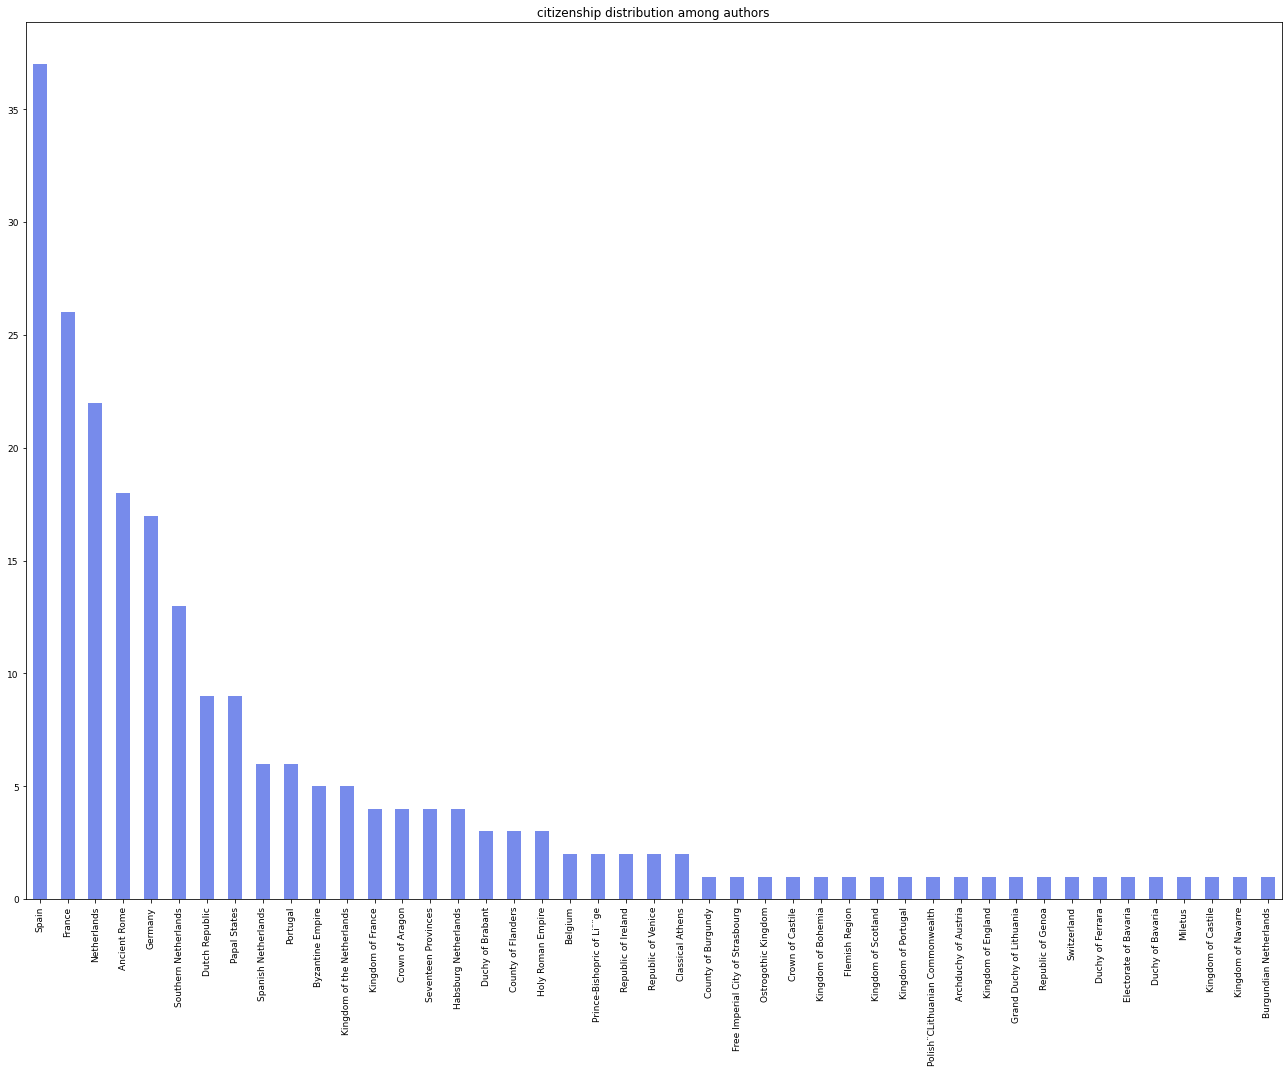

In [326]:
df_citizen= df_unique.dropna(subset=['country of citizenship'])
series_citizen =pd.Series(df_citizen['country of citizenship'].value_counts())
plt.figure()

ax = series_citizen.plot(
    kind='bar',
    title ="citizenship distribution among authors",
    figsize=(18, 15),
#     ylim=(2, 9),
    legend=False,
    color='#778beb',
    fontsize=9)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.tight_layout()
plt.show()
ax.figure.savefig('country distribution.pdf')

## Field of work

In [340]:
df_field = df_reconcile_clean.dropna(subset=['field of work'])
df_field.drop_duplicates(subset=['identifier','field of work'],keep='first')
series_field = df_field['field of work'].value_counts()

array(['philosophy', 'theology', 'monastic life',
       'administration and management of the church', 'scholasticism',
       'preaching', 'Christian ministry', 'scientific writing',
       'Christian mysticism', 'education', 'prayer',
       'religious formation', 'mysticism', 'poetry', 'asceticism',
       'religion', 'homiletics', 'politics', 'Reformation',
       'liturgical music', 'philology', 'lintel', 'canon law',
       'engraving process', 'art of painting', 'missionary work',
       'educational system', 'music', 'Counter-Reformation',
       'study of the Hebrew language', 'medicine', 'viticulture',
       'Greek philology', 'Christian Church', 'metal-engraving',
       'architecture', 'Christian philosophy', 'renaissance humanism',
       'religious literature', 'apologetics', 'historiography',
       'classical antiquity', 'linguistics', 'lexicography', 'Dutch',
       'Catholicism', 'pedagogy', 'history', 'logic', 'rhetoric',
       'humanism', 'chronology', 'poetics',

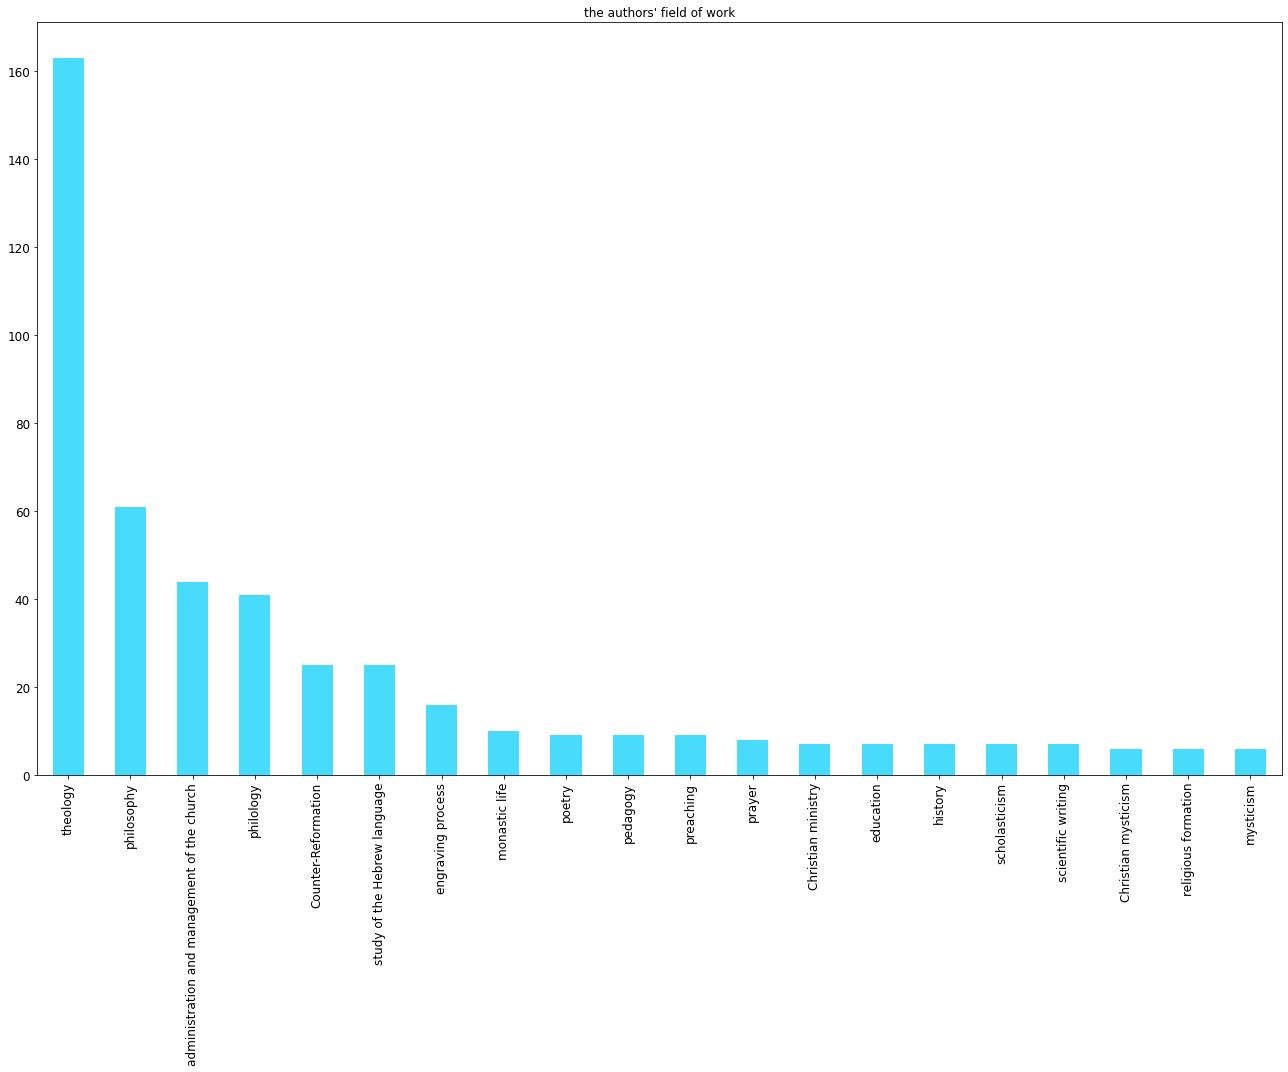

In [342]:
ax_field = series_field[0:20].plot(
    kind='bar',
    title ="the authors' field of work",
    figsize=(18, 15),
#     ylim=(2, 9),
    legend=False,
    color='#48dbfb',
    fontsize=12)
for tick in ax_edu.get_xticklabels():
    tick.set_rotation(90)
plt.tight_layout()
plt.show()
ax_field.figure.savefig('field of work.pdf')

## Occupation

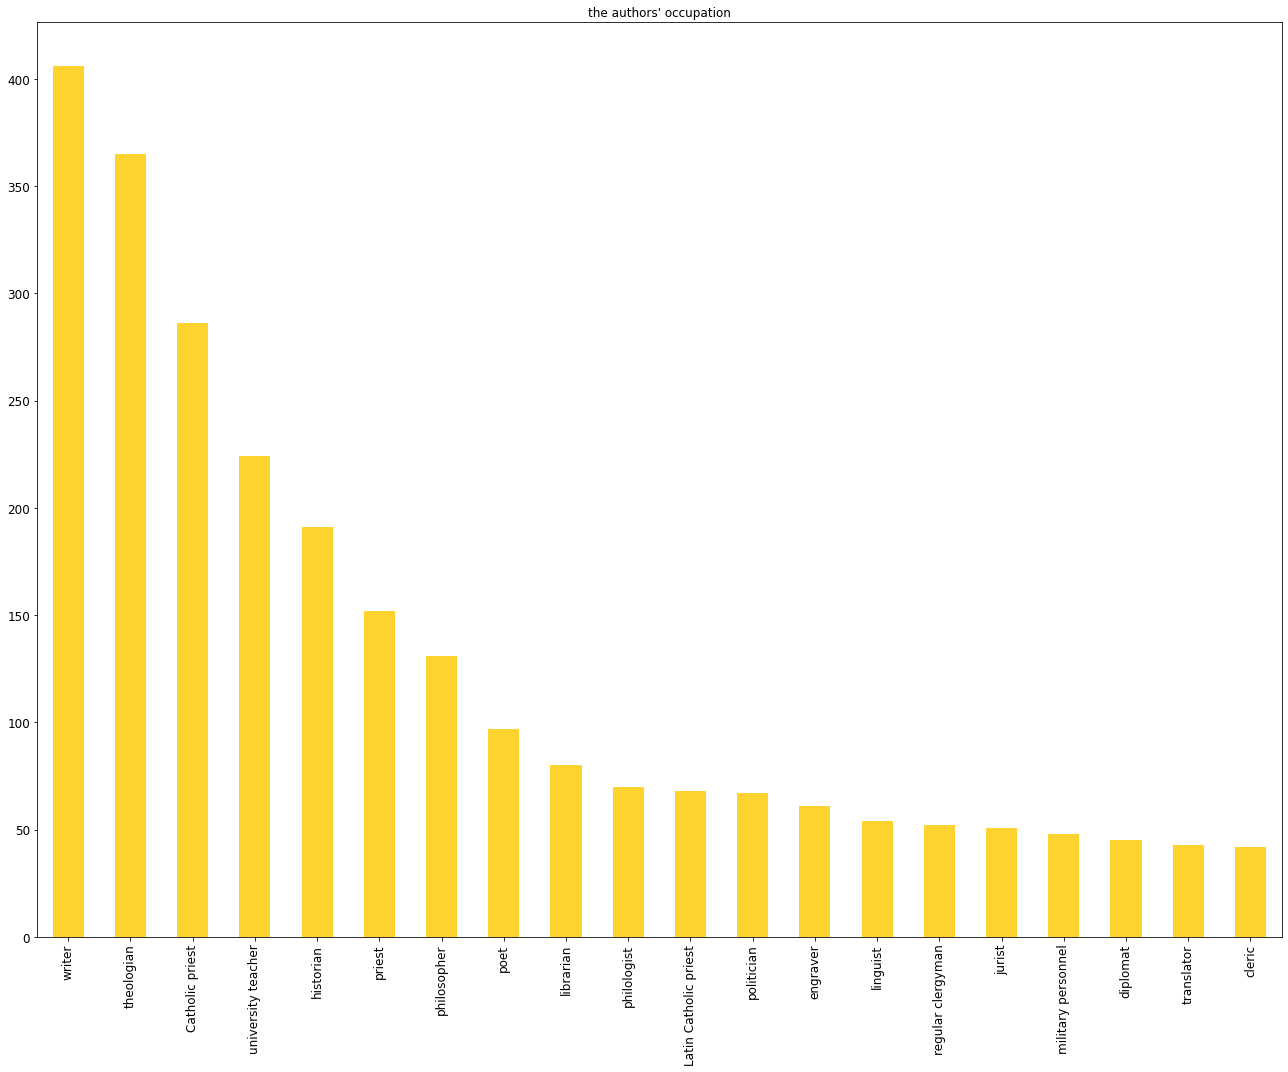

In [328]:
df_occupation = df_reconcile_clean.dropna(subset=['occupation'])
df_occupation.drop_duplicates(subset=['identifier','occupation'],keep='first')

series_occupation = df_occupation['occupation'].value_counts()
series_occupation
ax_occupation = series_occupation[0:20].plot(
    kind='bar',
    title ="the authors' occupation",
    figsize=(18, 15),
#     ylim=(2, 9),
    legend=False,
    color='#fed330',
    fontsize=12)
for tick in ax_occupation.get_xticklabels():
    tick.set_rotation(90)
plt.tight_layout()
plt.show()
ax_occupation.figure.savefig('occupation.pdf')

In [347]:
series_occupation[0:20]

writer                   406
theologian               365
Catholic priest          286
university teacher       224
historian                191
priest                   152
philosopher              131
poet                      97
librarian                 80
philologist               70
Latin Catholic priest     68
politician                67
engraver                  61
linguist                  54
regular clergyman         52
jurist                    51
military personnel        48
diplomat                  45
translator                43
cleric                    42
Name: occupation, dtype: int64

## Education

In [343]:
df_edu = df_reconcile_clean.dropna(subset=['educated at'])
df_edu.drop_duplicates(subset=['identifier','educated at'],keep='first')
series_edu = df_edu['educated at'].value_counts()
series_edu

Old University of Leuven             283
University of Douai                  137
University of Padua                   73
Pontifical Gregorian University       67
Universit¨¦ catholique de Louvain     50
                                    ... 
Queens' College                        1
University of Turin                    1
Merton College                         1
University of ¨¦vora                   1
University of Helmstedt                1
Name: educated at, Length: 63, dtype: int64

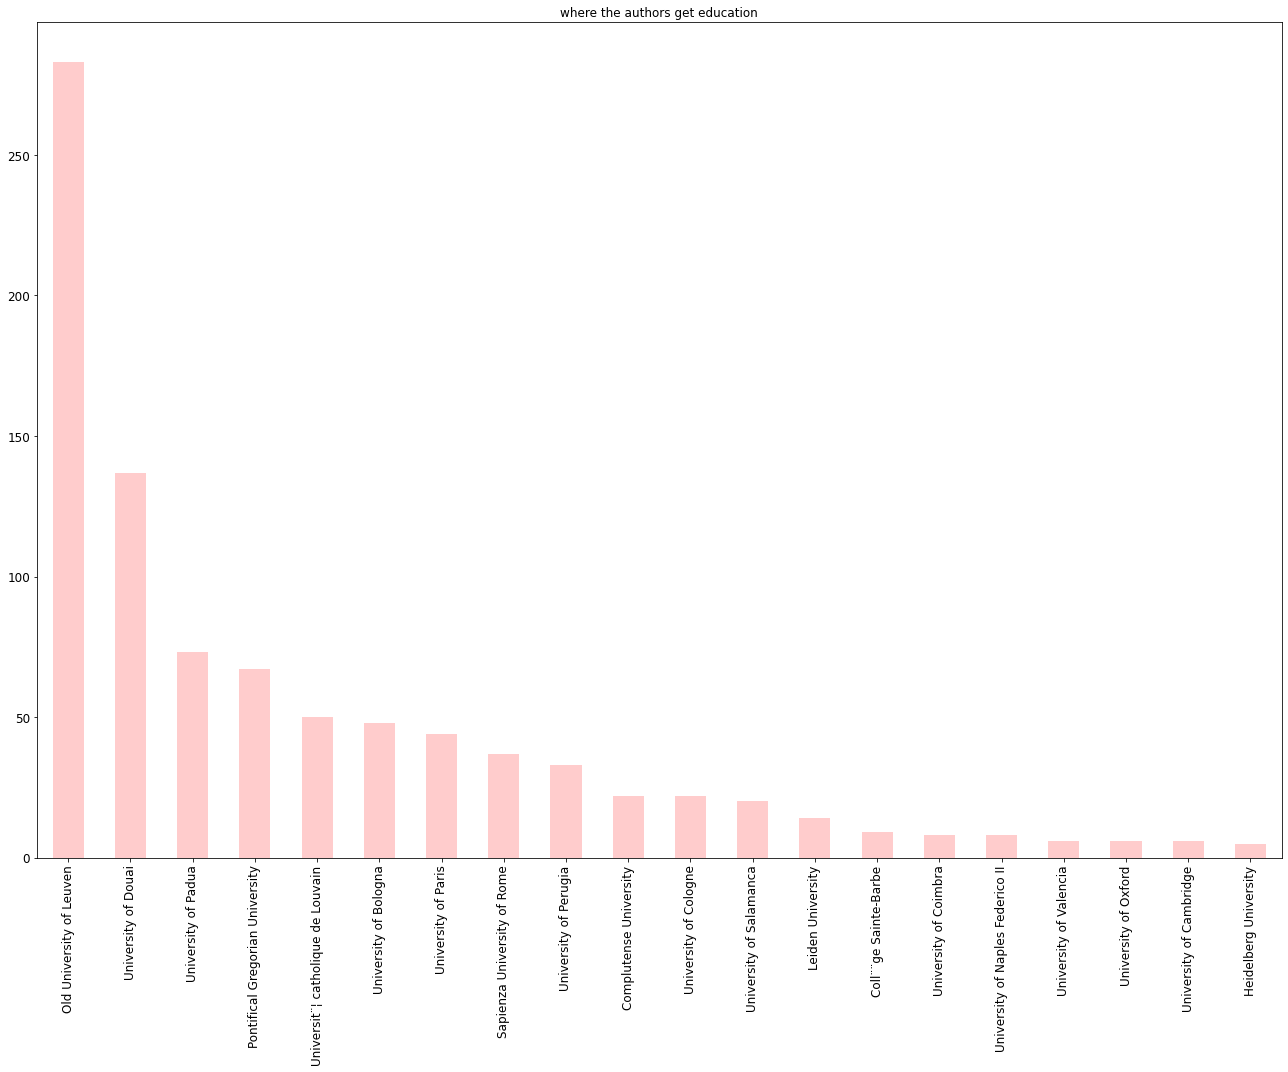

In [344]:
plt.figure()

ax_edu = series_edu[0:20].plot(
    kind='bar',
    title ="where the authors get education",
    figsize=(18, 15),
#     ylim=(2, 9),
    legend=False,
    color='#ffcccc',
    fontsize=12)
for tick in ax_edu.get_xticklabels():
    tick.set_rotation(90)
plt.tight_layout()
plt.show()
ax_edu.figure.savefig('education distribution.pdf')

In [348]:
df_edu['educated at'].value_counts()[0:20]

Old University of Leuven             283
University of Douai                  137
University of Padua                   73
Pontifical Gregorian University       67
Universit¨¦ catholique de Louvain     50
University of Bologna                 48
University of Paris                   44
Sapienza University of Rome           37
University of Perugia                 33
Complutense University                22
University of Cologne                 22
University of Salamanca               20
Leiden University                     14
Coll¨¨ge Sainte-Barbe                  9
University of Coimbra                  8
University of Naples Federico II       8
University of Valencia                 6
University of Oxford                   6
University of Cambridge                6
Heidelberg University                  5
Name: educated at, dtype: int64

## Use the cleaned data 

In [ ]:
df = pd.read_csv('Belgium-1601-1625_data.csv',encoding = 'latin1')
df.head()

### Publication Place Analysis

In [5]:
# Find out publication location distribution

In [7]:
publication_place = df['Place_of_publication'].dropna()
publication_place.unique()

array(['Antwerp', 'Ghent', 'Leuven', 'Brussels', 'En Brvsselas', 'Mons',
       'A Anvers', 'Ath', 'Li¨¨ge', 'Lvgdvni', 'Avgvst? Ebvronvum',
       'Montibvs', 'Mechelen', 'Tornaci Nerviorvm', 'V?neunt Lovanii',
       'Na de copie Tot Loven', 'S.l.', 'Eerst tot Antwerpen',
       'Pal?opoli Advaticorvm [=Antwerpen]', 'Dvaci', 'Gandavi',
       'A Tournay', 'Middelburgi', 'Parisiis', "Ghedruckt t' Antwerpen",
       'Gheprint Tantwerp?', 'A?Brvxelles', 'Antvverpi?',
       'Palaeopoli Advaticorum', 'Tot Antwerpen', 'Ipris', 'Tournai',
       'Amsterdam', 'Arras', 'Montibus Hannoniae', 'Bruges',
       'Lvgdni Batavorum', 'Lovvain', 'Athi', "t' Ypre",
       'Ypris Flandrorum', 'Paris', 'Louanij', 'LovenI', 'Avtverpi? [!]',
       'Ypre :', 'Ghedruckt tot Loven', '[plaats van uitgave onbekend]',
       'Courtrai', 'Cologne', 'Francofurti', "t'?Ipre", 'In Anverso',
       'Ghedruckt, te Ghendt', 'A Liege', 'Coloni? Agrippin?', 'A Brvges',
       'Tornaci', 'Metelloburgi Mattiacorum [= An

In [8]:
publication_place=publication_place.replace(['Lvgdvni','Louanij','Na de copie Tot Loven','V?neunt Lovanii','Lovvain','LovenI','Ghedruckt tot Loven','A Lovvain','Gedruckt tot Lueuen','Louany'],'Leuven')
publication_place=publication_place.replace(['A Anvers','Metelloburgi Mattiacorum [= Antwerp]','Avtverpi? [!]','Gheprint Tantwerp?','Pal?opoli Advaticorvm [=Antwerpen]', 'Eerst tot Antwerpen',"Ghedruckt t' Antwerpen",'Antvverpi?', 'Tot Antwerpen', 'Metelloburgi Mattiacorum [= Antwerp]',"gheprint t'Antvverpen",'Printed, at Antwarp', 'In Anverso'],'Antwerp')
publication_place=publication_place.replace(['Li¨¨ge','A Liege'],'Liege')
publication_place=publication_place.replace([ 'En Brvsselas','A?Brvxelles', 'Na de copije: tot Bruessel'],'Brussels')
publication_place=publication_place.replace([ 'A Brvges','Bruges'],'Bruges')
publication_place=publication_place.replace([ 'Tornaci','Tornaci Nerviorvm','A Tournay'],'Tournai')
publication_place=publication_place.replace(['Ghedruckt, te Ghendt','drucker tot Ghendt ghesworden','Gandavi'],'Ghent')

In [18]:
publication_place

1        Antwerp
3          Ghent
5          Ghent
7         Leuven
10      Brussels
          ...   
4379     Antwerp
4381     Antwerp
4383     Antwerp
4387     Antwerp
4391     Antwerp
Name: Place_of_publication, Length: 1252, dtype: object

In [19]:
df_publication = pd.DataFrame(publication_place)

In [20]:
df_publication

,Place_of_publication
1,Antwerp
3,Ghent
5,Ghent
7,Leuven
10,Brussels
...,...
4379,Antwerp
4381,Antwerp
4383,Antwerp
4387,Antwerp


In [21]:
df_publication['Place_of_publication'].unique()

array(['Antwerp', 'Ghent', 'Leuven', 'Brussels', 'Mons', 'Ath', 'Liege',
       'Avgvst? Ebvronvum', 'Montibvs', 'Mechelen', 'Tournai', 'S.l.',
       'Dvaci', 'Middelburgi', 'Parisiis', 'Palaeopoli Advaticorum',
       'Ipris', 'Amsterdam', 'Arras', 'Montibus Hannoniae', 'Bruges',
       'Lvgdni Batavorum', 'Athi', "t' Ypre", 'Ypris Flandrorum', 'Paris',
       'Ypre :', '[plaats van uitgave onbekend]', 'Courtrai', 'Cologne',
       'Francofurti', "t'?Ipre", 'Coloni? Agrippin?', 'Tot Lvyck'],
      dtype=object)

In [9]:
publication_place.value_counts()

Antwerp                          863
Leuven                           144
Brussels                         101
Liege                             34
Ghent                             28
Mons                              13
Tournai                            9
Mechelen                           8
S.l.                               6
Ath                                5
Montibvs                           5
t' Ypre                            4
Ipris                              3
Ypris Flandrorum                   3
t'?Ipre                            2
Montibus Hannoniae                 2
Bruges                             2
[plaats van uitgave onbekend]      2
Athi                               2
Dvaci                              2
Francofurti                        1
Cologne                            1
Ypre :                             1
Courtrai                           1
Coloni? Agrippin?                  1
Amsterdam                          1
Paris                              1
L

As shown in the List, most of the books were published in Belgium, while a very small portion of books were published in the nearby countries, such as in Paris and Amsterdam

Since the rest cities are either hard to recognize or too small to be include in term of publication number, here I am going to take the top 8 publication cities and map out the location

In [13]:
city_list = ['Antwerp','Leuven','Brussels','Liege', 'Ghent', 'Mons','Tournai' , 'Mechelen']

In [26]:
df_publication=pd.DataFrame(publication_place)
df_publication_top = df_publication.loc[df_publication['Place_of_publication'].isin(city_list)]
df_publication_top.value_counts()

Place_of_publication
Antwerp                 863
Leuven                  144
Brussels                101
Liege                    34
Ghent                    28
Mons                     13
Tournai                   9
Mechelen                  8
dtype: int64

In [32]:
df_publication_top.rename(columns={'Place_of_publication':'city'},inplace=True)

C:\Users\95327\AppData\Local\Temp\ipykernel_85392\3348102191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_publication_top.rename(columns={'Place_of_publication':'city'},inplace=True)


In [36]:
df_publication_top.city

1        Antwerp
3          Ghent
5          Ghent
7         Leuven
10      Brussels
          ...   
4379     Antwerp
4381     Antwerp
4383     Antwerp
4387     Antwerp
4391     Antwerp
Name: city, Length: 1200, dtype: object

In [40]:
df_publication_top.index

Int64Index([   1,    3,    5,    7,   10,   11,   13,   15,   19,   21,
            ...
            4369, 4371, 4373, 4375, 4377, 4379, 4381, 4383, 4387, 4391],
           dtype='int64', length=1200)

In [42]:
df_publication_top['lat']=None
df_publication_top['lng']=None

C:\Users\95327\AppData\Local\Temp\ipykernel_85392\3627899683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_publication_top['lat']=None
C:\Users\95327\AppData\Local\Temp\ipykernel_85392\3627899683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_publication_top['lng']=None


In [43]:
# Search for the latitude and longitude of the 8 cities and add to the dataframe
for i in df_publication_top.index:
    if df_publication_top.city[i] == 'Antwerp':
        df_publication_top['lat'][i]=51.260197
        df_publication_top['lng'][i]=4.402771
    elif df_publication_top.city[i] == 'Leuven':
        df_publication_top['lat'][i]=50.879590
        df_publication_top['lng'][i]=4.700930
    elif df_publication_top.city[i] == 'Brussels':
        df_publication_top['lat'][i]=50.850450
        df_publication_top['lng'][i]=4.348780
    elif df_publication_top.city[i] == 'Liege':
        df_publication_top['lat'][i]=50.633730
        df_publication_top['lng'][i]=5.567490
    elif df_publication_top.city[i] == 'Ghent':
        df_publication_top['lat'][i]=51.050000
        df_publication_top['lng'][i]=3.716670
    elif df_publication_top.city[i] == 'Mons':
        df_publication_top['lat'][i]=50.454130
        df_publication_top['lng'][i]=3.389320
    elif df_publication_top.city[i] == 'Tournai':
        df_publication_top['lat'][i]=50.607150
        df_publication_top['lng'][i]=4.348780
    elif df_publication_top.city[i] == 'Mechelen':
        df_publication_top['lat'][i]=51.025740
        df_publication_top['lng'][i]=4.477620     

C:\Users\95327\AppData\Local\Temp\ipykernel_85392\339842640.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_publication_top['lat'][i]=51.260197
C:\Users\95327\AppData\Local\Temp\ipykernel_85392\339842640.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_publication_top['lng'][i]=4.402771
C:\Users\95327\AppData\Local\Temp\ipykernel_85392\339842640.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_publication_top['lat']

In [24]:
latitude= 50.850450
longitude=4.348780

bel_map = folium.Map(location = [latitude,longitude],zoom_start = 8)

In [44]:
bel_map

In [46]:
publication = plugins.MarkerCluster().add_to(bel_map)
for lat, lng in zip(df_publication_top.lat,df_publication_top.lng):
    folium.Marker(
    location=[lat,lng],
    icon=None).add_to(publication)
bel_map.add_child(publication)

Book publishers were scattered throughout Belgium, and most of book were published in the centre and north, namely Antwerp, Leuven and Brussels, which became the major cities of Belgium later on.

### publication language analysis

In [10]:
languages= df['publication_language'].dropna()
languages

0       lat
2       dut
4       dut
6       dut
9       dut
       ... 
4378    lat
4380    lat
4382    dut
4386    dut
4390    lat
Name: publication_language, Length: 1143, dtype: object

In [11]:
# Find out what languages are used in the ancient books
languages.unique()

array(['lat', 'dut', 'spa', 'fre', 'heb', 'per', 'grc', 'eng'],
      dtype=object)

In [12]:
# Find out language distribution 
languages.value_counts()

lat    700
dut    352
fre     75
spa     10
grc      3
heb      1
per      1
eng      1
Name: publication_language, dtype: int64

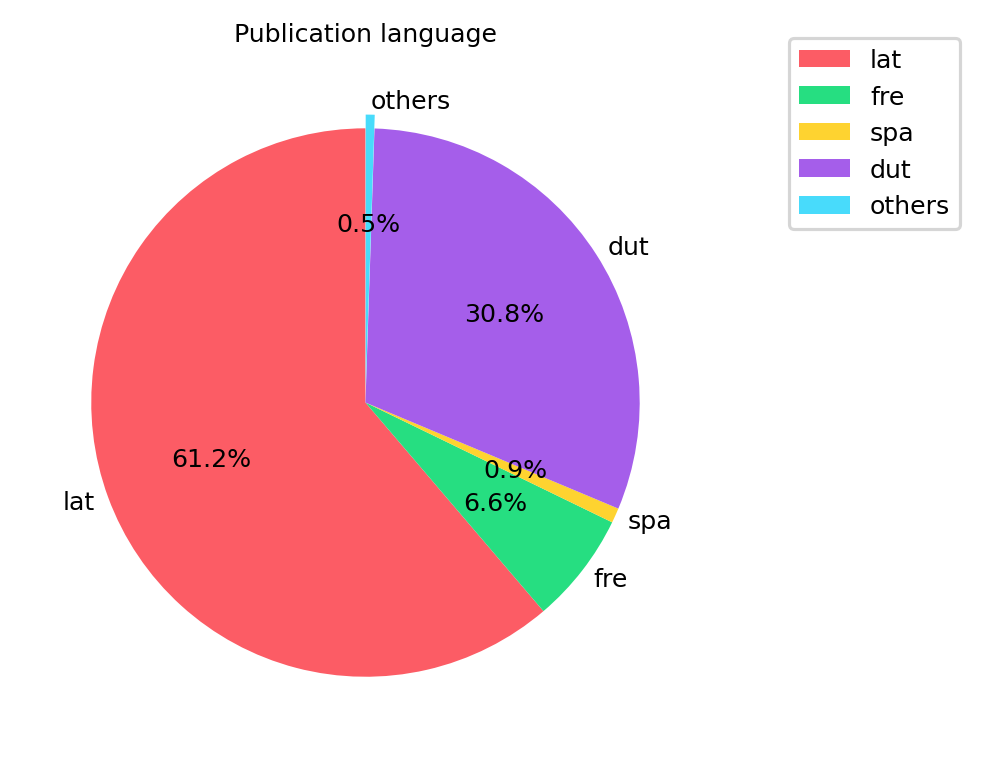

In [18]:
labels=['lat', 'fre','spa', 'dut','others']
sizes=[700,75,10,352,6]
plt.figure(figsize=(4,4),dpi=227)
explode = (0,0,0,0,0.05)
custom_colors=['#fc5c65','#26de81','#fed330','#a55eea','#48dbfb']
# ,textprops={'fontsize':6},

plt.pie(sizes,labels=labels,labeldistance=1.05,startangle=90,textprops={'fontsize':8},colors=custom_colors,explode=explode,autopct='%1.1f%%',pctdistance=0.6)
plt.legend(bbox_to_anchor=(1.1,1.05),fontsize=8,labels=labels)
plt.title('Publication language',fontsize = 8)
plt.show()

As shown in the picture, among all the publication languages, Latin makes up the majority, with Dutch coming in second at 30.6%.

## linguistic features

### latin

In [21]:
#In this case I would use the most popular two language, the latin and dutch to find out the linguistic feature
title= df['Main_title'].dropna()
title

0       F. Henrici SedvlI ... Pr?scriptiones adversvs ...
2                                  Den crvys-wech Christi
4       Kalengier ende lvst-hof der H. kercke verciert...
6       Den christelycken spieghel, om wel ende deuchd...
9       Edicht ende ordinancie vande eertzhertogen ons...
                              ...                        
4378    C. Ivlii C?saris Commentariorvm de bello civil...
4380    M. Tvllii Ciceronis Pro lege Manilia ad popvlv...
4382    Soliloqvivm oft Alleenspraecke des H. seraphis...
4386            Van des vvereldts ydelheden te versmaden.
4390    F. Henrici Sedvlii ... Apologeticvs aduersus A...
Name: Main_title, Length: 1357, dtype: object

In [24]:
df_latin = df.loc[df['publication_language']=='lat']
title_latin = df_latin['Main_title'].dropna()

In [29]:
latin_stopword='ab, ac, ad, adhic, aliqui, aliquis, an, ante, apud, at, atque, aut, autem, cum, cur, de, deinde, dum, ego, enim, ergo, es, est, et, etiam, etsi, ex, fio, haud, hic, iam, idem, igitur, ille, in, infra, inter, interim, ipse, is, ita, magis, modo, mox, nam, ne, nec, necque, neque, nisi, non, nos, o, ob, per, possum, post, pro, quae, quam, quare, qui, quia, quicumque, quidem, quilibet, quis, quisnam, quisquam, quisque, quisquis, quo, quoniam, sed, si, sic, sive, sub, sui, sum, super, suus, tam, tamen, trans, tu, tum, ubi, uel, uero, unus, ut'
latin_stopword=latin_stopword.split(', ')
latin_stopword

['ab',
 'ac',
 'ad',
 'adhic',
 'aliqui',
 'aliquis',
 'an',
 'ante',
 'apud',
 'at',
 'atque',
 'aut',
 'autem',
 'cum',
 'cur',
 'de',
 'deinde',
 'dum',
 'ego',
 'enim',
 'ergo',
 'es',
 'est',
 'et',
 'etiam',
 'etsi',
 'ex',
 'fio',
 'haud',
 'hic',
 'iam',
 'idem',
 'igitur',
 'ille',
 'in',
 'infra',
 'inter',
 'interim',
 'ipse',
 'is',
 'ita',
 'magis',
 'modo',
 'mox',
 'nam',
 'ne',
 'nec',
 'necque',
 'neque',
 'nisi',
 'non',
 'nos',
 'o',
 'ob',
 'per',
 'possum',
 'post',
 'pro',
 'quae',
 'quam',
 'quare',
 'qui',
 'quia',
 'quicumque',
 'quidem',
 'quilibet',
 'quis',
 'quisnam',
 'quisquam',
 'quisque',
 'quisquis',
 'quo',
 'quoniam',
 'sed',
 'si',
 'sic',
 'sive',
 'sub',
 'sui',
 'sum',
 'super',
 'suus',
 'tam',
 'tamen',
 'trans',
 'tu',
 'tum',
 'ubi',
 'uel',
 'uero',
 'unus',
 'ut']

In [42]:
title_as_string = ' '.join(title_latin)

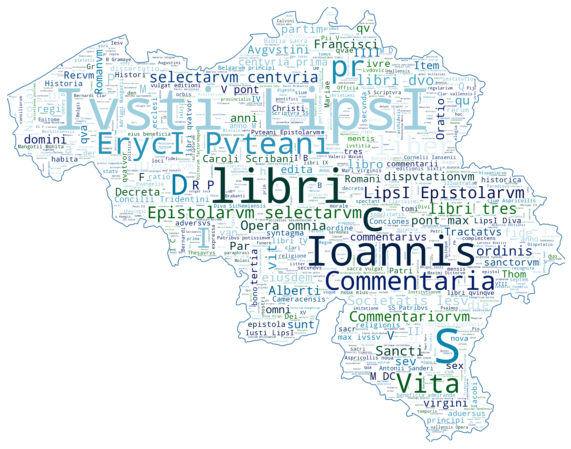

In [43]:
belguim_file = 'belgium.png'
icon=Image.open(belguim_file).convert("RGBA")  
image_mask=Image.new(mode='RGB',size=icon.size,color=(255,255,255))
image_mask.paste(icon,box=icon)


rgb_array=np.array(image_mask)


word_cloud=WordCloud(mask=rgb_array,background_color='white',stopwords=latin_stopword,max_words=1000,colormap='ocean',contour_width=3,contour_color='steelblue')
word_cloud.generate(title_as_string)

plt.figure(figsize=[16,8])

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

As shown in the picture
Ivsti LipsI
ErycI Pvteni
LispI Epistolarvm
Ioannis
Commentaria

### dutch

In [45]:
df_dutch = df.loc[df['publication_language']=='dut']
title_dutch = df_dutch['Main_title'].dropna()

In [53]:
title_dutch

2                                  Den crvys-wech Christi
4       Kalengier ende lvst-hof der H. kercke verciert...
6       Den christelycken spieghel, om wel ende deuchd...
9       Edicht ende ordinancie vande eertzhertogen ons...
14      Een gulden boecxken ghenoemt De conste om Godt...
                              ...                        
4339                             Beghijnken van Machelen,
4347    Den oorspronck ende cavse vande iaerlicxsche f...
4355    De gheestelycke vryagie, waer Christvs de ziel...
4382    Soliloqvivm oft Alleenspraecke des H. seraphis...
4386            Van des vvereldts ydelheden te versmaden.
Name: Main_title, Length: 352, dtype: object

In [50]:
title_as_string = ' '.join(title_dutch)

In [54]:
title_as_string

"Den crvys-wech Christi Kalengier ende lvst-hof der H. kercke verciert met den salighen crvys-wech Christi ... Den christelycken spieghel, om wel ende deuchdelijck te leuen. Voor alle vaders ende moeders des huysgesins, ende alle die in ouerheyt zijn. Edicht ende ordinancie vande eertzhertogen onse souuereyne princen op't stueck ende exercicie van d'ambacht ande goudt ende-silver-smeden, ende 't ghene daer aen cleeft inde landen van het herwaertsovere Een gulden boecxken ghenoemt De conste om Godt oprechtelyck te dienen. De innighe alleensprake des eervv. broeders Gerlacvs Peterssen, ... De seven ghetijden van onse Lieve Vrouwe na het Roomsch ghebruyck, ... Gheboden ende wt-gheroepen by mijnen heeren ... der stadt van Antwerpen, op den xxiiij. decembris, 1619. Men laet weten ende ordonneert van 's heeren ende deser stadts wegen, dat een yeghelijck vande borgheren ende inghesetenen deser stadt sal schuldigh ende ghehouden zijn te betaelen den staeten impost op't vee ... Gheboden ende wt

In [55]:
dutch_stopword = set(stopwords.words('dutch'))

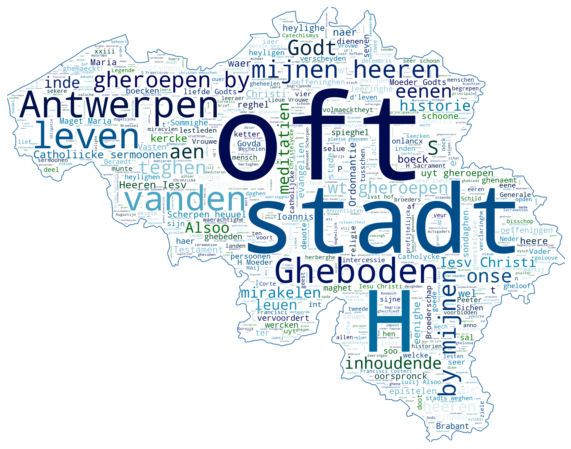

In [56]:
word_cloud=WordCloud(mask=rgb_array,background_color='white',stopwords=dutch_stopword,max_words=1000,colormap='ocean',contour_width=3,contour_color='steelblue')
word_cloud.generate(title_as_string)

plt.figure(figsize=[16,8])

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

 There are also places for example 'leuven','Antwerp'

### french

In [58]:
df_french = df.loc[df['publication_language']=='fre']
title_french = df_french['Main_title'].dropna()
title_french

175     Practiqve de la perfection et des vertvs chres...
180     La ivstice de S. A. imploree povr la deffense ...
223          Le pelerin moral de F. Bernard dv Verger ...
238     Contemplations tres-pievses svr le crvcifix, e...
243                                  Miroir de discipline
                              ...                        
4237    Histoire de la vie, miracles et translation de...
4288    Histoire des miracles advenvz n'agveres a l'in...
4292    Histoire des miracles advenvz n'agveres a l'in...
4305    Avtres miracles de Nostre Dame av Mont-aigv ad...
4322    Ordonnance et edict perpetvel des archidvcqz ....
Name: Main_title, Length: 75, dtype: object

In [61]:
french_stopword = set(stopwords.words('french'))

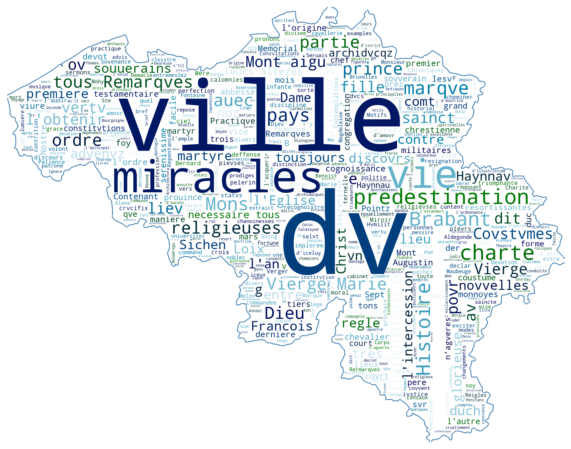

In [62]:
title_as_string = ' '.join(title_french)
word_cloud=WordCloud(mask=rgb_array,background_color='white',stopwords=french_stopword,max_words=1000,colormap='ocean',contour_width=3,contour_color='steelblue')
word_cloud.generate(title_as_string)

plt.figure(figsize=[16,8])

plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

In [44]:
# the most common words in different languages

## Social Network Analysis

In [51]:
series_authors = df['700'].dropna()

In [52]:
series_authors

0       ^$1$ $aSedulius, Henricus$ $ $cO.F.M.$ $ $d154...
2                      ^$1$ $ade Coster, Gillis.$ $ $4aut
4                      ^$1$ $ade Coster, Gillis.$ $ $4aut
6       ^$1$ $aAlonso de Madrid$ $ $cO.F.M.$ $ $d1480-...
9       ^$0$ $aAlbrecht$ $ $bVII$ $ $cArchduke of Aust...
                              ...                        
4378    ^$1$ $aCaesar, Caius Julius$ $ $d100 BC-44 BC$...
4380    ^$1$ $aCicero, Marcus Tullius$ $ $d106 BC-43 B...
4382    ^$1$ $aBonaventura$ $ $cO.F.M.$ $ $d1221-1274$...
4386    ^$1$ $aStella, Didacus$ $ $cO.F.M.$ $ $d1524-1...
4390    ^$1$ $aSedulius, Henricus$ $ $cO.F.M.$ $ $d154...
Name: 700, Length: 1233, dtype: object

In [53]:
authors = []
roles = []
for i in series_authors:
    patern1 = re.compile(r'\^\$\d\$\s\$\w(.*?)\$')
    patern2 = re.compile(r'\$\s\$\s\$4(\w\w\w)')
    author = patern1.findall(i)
    role = patern2.findall(i)
    authors.append(author)
    roles.append(role)

In [141]:
# Find out the average number of authors for a book
length_author=[]
for i in authors:
    length_author.append(len(i))
length_author_series = pd.DataFrame(length_author)
length_author_series.mean()

0    2.135442
dtype: float64

In [154]:
(length_author_series==1).sum()

0    569
dtype: int64

In [155]:
length_author_series.max()

0    39
dtype: int64

There are 569 book who were written by independent author, the average author for a book is 2.13, and the book with the most authors is 'Ivsti LipsI sapienti? et litterarvm antistitis fama postuma', with 39 authors accomplishing it together.

In [143]:
len(length_author_series)

1233

In [144]:
len(length_author_series)

1233

In [84]:
df_authors = pd.DataFrame(authors)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,"Sedulius, Henricus",None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,"de Coster, Gillis.",None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,"de Coster, Gillis.",None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,Alonso de Madrid,"vanden Broecke, Franciscus",None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,Albrecht,Isabella Clara Eugenia,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,"Caesar, Caius Julius",None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1229,"Cicero, Marcus Tullius",None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1230,Bonaventura,"Collaert, Jan Baptist","Thielmans, Cornelius",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1231,"Stella, Didacus","Van Blitterswyck, Jan","Van Blitterswyck, Maria",None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [85]:
df_roles = pd.DataFrame(roles)
df_roles

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,aut,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,aut,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,aut,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,aut,trl,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,oth,oth,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1228,aut,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1229,aut,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1230,aut,egr,trl,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1231,aut,trl,dte,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [90]:
author_role=[]
for i in range(0,39):
    for j in range(0,1233):
        author_role.append((df_authors[i][j],df_roles[i][j]))
        

In [91]:
author_role

[('Sedulius, Henricus', 'aut'),
 ('de Coster, Gillis.', 'aut'),
 ('de Coster, Gillis.', 'aut'),
 ('Alonso de Madrid', 'aut'),
 ('Albrecht', 'oth'),
 ('Alonso de Madrid', 'aut'),
 ('Junius, Balduinus', 'aut'),
 ('Caesarius Heisterbacensis.', 'aut'),
 ('Gerlach Peters', 'aut'),
 ('Arnoldus ab Isca', 'trl'),
 ('de Guevara, Antonio', 'aut'),
 ('Arnoldus ab Isca', 'trl'),
 ('Arnoldus ab Isca', 'trl'),
 ('Florus, Lucius Annaeus.', 'aut'),
 ('Albrecht', 'aut'),
 ('Vanden Berghe, Joannes.', 'dfr'),
 ('Bijns, Anna.', 'aut'),
 ('Jordan, Raymondus', 'aut'),
 ('Godefridi, Petrus', 'edt'),
 ('Thomas Aquinas', 'aut'),
 ('Florianus, Joannes.', 'trl'),
 ('Campi de Salutio, Bartholomeus', 'aut'),
 ('Smising, Theodorus', 'aut'),
 ('Spoelbergh, Guilielmus', 'com'),
 ('Bonaventura', 'aut'),
 ('Makeblijde, Lodewijk', 'aut'),
 ('Bonaventura', 'aut'),
 ('de Soto, Andreas', 'aut'),
 ('Aegidius Aureaevalensis', 'aow'),
 ('Duez, Paul', 'trl'),
 ('Herman, Hugo', 'aut'),
 ('Bernardus Claraevallensis', 'aut'),
 ('

In [98]:
while (None, None) in author_role:
    author_role.remove((None,None))

In [99]:
len(author_role)

2638

In [ ]:
#Find out people who play multiple roles

In [100]:
author_role_series = pd.Series(author_role)
author_role_series.value_counts()

(Lipsius, Justus, aut)                   68
(Puteanus, Erycius, aut)                 34
(Costerus, Franciscus, aut)              34
(Lessius, Leonardus, aut)                27
(Scribani, Carolus, aut)                 26
                                         ..
(Moretus, Balthasar, edt)                 1
(Divaeus, Petrus, aut)                    1
(Baeckx van Baerlandt, Adrianus, ctb)     1
(Favre, Antoine, clb)                     1
(toe Boecop, Arent, ctb)                  1
Length: 1416, dtype: int64

In [106]:
s= author_role_series.unique()

In [115]:
multi_role=[]
for i in range(0,1416):
    for j in range(i+1, 1416):
        if s[i][0]==s[j][0]:
            multi_role.append(s[i])
            multi_role.append(s[j])
        

In [116]:
multi_role

[('Sedulius, Henricus', 'aut'),
 ('Sedulius, Henricus', 'oth'),
 ('Sedulius, Henricus', 'aut'),
 ('Sedulius, Henricus', 'edt'),
 ('Albrecht', 'oth'),
 ('Albrecht', 'aut'),
 ('Albrecht', 'oth'),
 ('Albrecht', 'dte'),
 ('Albrecht', 'oth'),
 ('Albrecht', 'apb'),
 ('Junius, Balduinus', 'aut'),
 ('Junius, Balduinus', 'com'),
 ('Florus, Lucius Annaeus.', 'aut'),
 ('Florus, Lucius Annaeus.', 'ctb'),
 ('Albrecht', 'aut'),
 ('Albrecht', 'dte'),
 ('Albrecht', 'aut'),
 ('Albrecht', 'apb'),
 ('Godefridi, Petrus', 'edt'),
 ('Godefridi, Petrus', 'aut'),
 ('Thomas Aquinas', 'aut'),
 ('Thomas Aquinas', 'pub'),
 ('Thomas Aquinas', 'aut'),
 ('Thomas Aquinas', 'aow'),
 ('Thomas Aquinas', 'aut'),
 ('Thomas Aquinas', 'oth'),
 ('Spoelbergh, Guilielmus', 'com'),
 ('Spoelbergh, Guilielmus', 'trl'),
 ('Spoelbergh, Guilielmus', 'com'),
 ('Spoelbergh, Guilielmus', 'aut'),
 ('Spoelbergh, Guilielmus', 'com'),
 ('Spoelbergh, Guilielmus', 'eul'),
 ('Makeblijde, Lodewijk', 'aut'),
 ('Makeblijde, Lodewijk', 'trl'),
 (

In [117]:
d=defaultdict(list)

In [118]:
for key,value in multi_role:
    d[key].append(value)
multi_role_list=[]
for i in d.items():
    multi_role_list.append(i)
multi_role_list

[('Sedulius, Henricus', ['aut', 'oth', 'aut', 'edt', 'oth', 'edt']),
 ('Albrecht',
  ['oth',
   'aut',
   'oth',
   'dte',
   'oth',
   'apb',
   'aut',
   'dte',
   'aut',
   'apb',
   'dte',
   'apb']),
 ('Junius, Balduinus', ['aut', 'com']),
 ('Florus, Lucius Annaeus.', ['aut', 'ctb']),
 ('Godefridi, Petrus', ['edt', 'aut']),
 ('Thomas Aquinas',
  ['aut',
   'pub',
   'aut',
   'aow',
   'aut',
   'oth',
   'pub',
   'aow',
   'pub',
   'oth',
   'aow',
   'oth']),
 ('Spoelbergh, Guilielmus',
  ['com',
   'trl',
   'com',
   'aut',
   'com',
   'eul',
   'trl',
   'aut',
   'trl',
   'eul',
   'aut',
   'eul']),
 ('Makeblijde, Lodewijk', ['aut', 'trl']),
 ('de Soto, Andreas', ['aut', 'aow', 'aut', 'trl', 'aow', 'trl']),
 ('de Covarrubias y Leyva, Diego', ['dte', 'aut']),
 ('Collaert, Jan', ['egr', 'ill']),
 ('Lipsius, Justus',
  ['aut',
   'edt',
   'aut',
   'oth',
   'aut',
   'ann',
   'aut',
   'eul',
   'aut',
   'pub',
   'aut',
   'dte',
   'aut',
   'ctb',
   'aut',
   'dpc'

In [120]:
df_author_role = pd.DataFrame(multi_role_list)

In [121]:
df_author_role

,0,1
0,"Sedulius, Henricus","[aut, oth, aut, edt, oth, edt]"
1,Albrecht,"[oth, aut, oth, dte, oth, apb, aut, dte, aut, ..."
2,"Junius, Balduinus","[aut, com]"
3,"Florus, Lucius Annaeus.","[aut, ctb]"
4,"Godefridi, Petrus","[edt, aut]"
...,...,...
177,"Bochius, Joannes","[eul, ctb]"
178,"Bulteel, Gislain","[eul, ctb]"
179,"Segeth, Thomas","[eul, ctb]"
180,"Bircovius, Simon","[ctb, eul]"


In [134]:
df_author_role.rename(columns={0:'name'},inplace = True)
df_author_role.rename(columns={1:'role'},inplace = True)

In [137]:
df_author_role.set_index('name',inplace=True)

In [138]:
df_author_role.loc['Albrecht']

role    [oth, aut, oth, dte, oth, apb, aut, dte, aut, ...
Name: Albrecht, dtype: object

In [156]:
authors

[['Sedulius, Henricus'],
 ['de Coster, Gillis.'],
 ['de Coster, Gillis.'],
 ['Alonso de Madrid', 'vanden Broecke, Franciscus'],
 ['Albrecht', 'Isabella Clara Eugenia'],
 ['Alonso de Madrid', 'Farzyn, Jacobus', 'Henten, Johannes'],
 ['Junius, Balduinus'],
 ['Caesarius Heisterbacensis.'],
 ['Gerlach Peters', 'van Gorcum, Jan', 'van Heese, Nicasius'],
 ['Arnoldus ab Isca'],
 ['de Guevara, Antonio'],
 ['Arnoldus ab Isca', 'vanden Calster, Anna.'],
 ['Arnoldus ab Isca'],
 ['Florus, Lucius Annaeus.'],
 ['Albrecht', 'Isabella Clara Eugenia'],
 ['Vanden Berghe, Joannes.'],
 ['Bijns, Anna.', 'Pippinck, B. Henrick.'],
 ['Jordan, Raymondus', 'van Alen, Jan'],
 ['Godefridi, Petrus', 'Vervoort, Frans'],
 ['Thomas Aquinas'],
 ['Florianus, Joannes.', 'Ovidius Naso, Publius'],
 ['Campi de Salutio, Bartholomeus', 'Van Blitterswyck, Jan'],
 ['Smising, Theodorus', 'von Hohenzollern-Sigmaringen, Eitel Friedrich'],
 ['Spoelbergh, Guilielmus'],
 ['Bonaventura', 'Spoelbergh, Guilielmus'],
 ['Makeblijde, Lode

In [307]:
# To see how active the author is

#Flatten the nested list
author_list = []
for i in authors:
    for j in i:
        author_list.append(j)
        
author_count = {}
for i in author_list:
    if i not in author_count:
        author_count[i]=1
    else:
        author_count[i]+=1

# sort active author frequency

sort_author_frequency = [(c,a) for a,c in author_count.items()] 
sort_author_frequency.sort(reverse=True)
sort_author_frequency = [(a,c) for c,a in sort_author_frequency]
sort_author_frequency

[('Lipsius, Justus', 97),
 ('Puteanus, Erycius', 43),
 ('Albrecht', 37),
 ('Isabella Clara Eugenia', 36),
 ('Costerus, Franciscus', 36),
 ('Lessius, Leonardus', 32),
 ('Scribani, Carolus', 30),
 ('Hovius, Matthias', 30),
 ('Bellarmino, Roberto', 25),
 ('Miraeus, Aubertus', 24),
 ('Spoelbergh, Guilielmus', 20),
 ('Makeblijde, Lodewijk', 20),
 ('Numan, Philippus', 19),
 ('Gramaye, Joannes Baptista', 19),
 ('David, Jan', 18),
 ('a Lapide, Cornelius Cornelii', 16),
 ('Galle, Theodoor', 16),
 ('Beyerlinck, Laurentius', 16),
 ('Rosweydus, Heribertus', 15),
 ('Galle, Cornelius', 15),
 ('Vrientius, Maximus Aemylianus', 14),
 ('Sailly, Thomas', 14),
 ('de Gouda, Joannes', 13),
 ('Hugo, Herman', 12),
 ('Stratius, Jacobus', 11),
 ('Paul', 11),
 ('de Soto, Andreas', 10),
 ('Thomas a Kempis', 10),
 ('Sedulius, Henricus', 10),
 ('Schott, Andr¨¦', 10),
 ('Rubens, Peter Paul', 10),
 ('Baronius, Caesar', 10),
 ('Aquaviva, Claudius', 10),
 ('de Winghe, Antonius', 9),
 ('Sweerts, Pierre Fran?ois', 9),
 (

In [167]:
unique_author = set(author_list)
unique_author

{'de Ramires, Maria',
 'Jacobs, Joannes',
 'Brouwer, Christophorus',
 'von Bayern, Ferdinand',
 'De Balinghem, Antonius',
 'Paludanus, Johannes',
 'Herman, Hugo',
 'Clenardus, Nicolaus',
 'de Petter, Hieronymus',
 'de Wannemaker, Philippus',
 'Divaeus, Petrus',
 'Joannes',
 'Junius, Cornelius',
 'Corenus, Jacobus',
 'de Casta?iza, Juan',
 'Bartholomaeus a Salutio.',
 'Vorsterman, Lucas Emil',
 'van de Casteele, Peeter',
 'Martianus Rota, Julius',
 'de Schietere, Josse',
 'Gregory',
 'de Montgaillard, Bernard',
 'Baius, Jacobus',
 'vanden Borgh, Jacobus',
 'Collaert, Jan',
 'Plancius, Daniel',
 'Cornaro, Luigi',
 'De Ribadeneira, Pedro',
 'Martinez van Waucquier, Matthias',
 'Maillart, Pierre',
 'Bourgeois, Joannes',
 'Hermannus, Heriod.',
 'van Eynatten, Maximilian',
 'Wilhelm',
 'de Pretere, Guillaume',
 'Pr¨®chnicki, Jan Andrzej',
 'de Barnaige, Chrestienne',
 'Vrancx, Cornelius Columbanus',
 'Bijns, Anna.',
 'Riserius, Johann',
 'Aquaviva, Claudio',
 'de Br¨¦tigny, Jean',
 'Clement'

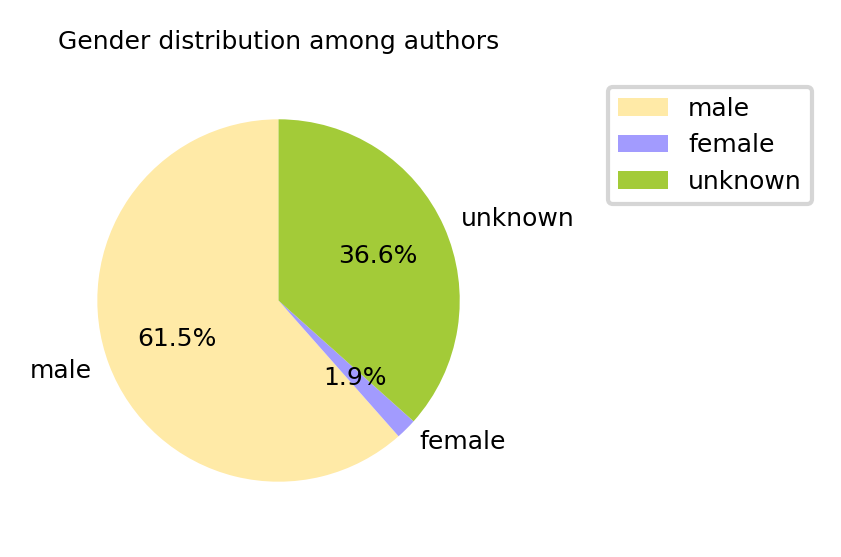

In [198]:
#Find out gender distribution among all the author
firstname=[]
for i in unique_author:
    name = i.split(', ')
    firstname.append(name[-1])
    
gender = []
gender_detector= gender_guesser.detector.Detector()
for name in firstname:
    guess = gender_detector.get_gender(name)
    gender.append(guess)
    
gender_series = pd.Series(gender)
sum_male=sum(gender_series=='male')
sum_female=sum(gender_series=='female')
sum_unknown=sum(gender_series=='unknown')
category_names=['male','female','unknown']
sizes=[sum_male,sum_female,sum_unknown]
plt.figure(figsize=(2,2),dpi=300)
custom_colors=['#ffeaa7','#a29bfe','#A3CB38']
plt.pie(sizes,labels=category_names,textprops={'fontsize':6},startangle=90,colors=custom_colors,autopct='%1.1f%%')
plt.title("Gender distribution among authors",fontsize=6) 
plt.legend(bbox_to_anchor=(1.2, 1),fontsize=6)
plt.show()

In [ ]:
# To find out the authors' social network

In [157]:
network_list = []
for i in authors:
    if len(i)>1:
        network_list.append(i)
network_list

[['Alonso de Madrid', 'vanden Broecke, Franciscus'],
 ['Albrecht', 'Isabella Clara Eugenia'],
 ['Alonso de Madrid', 'Farzyn, Jacobus', 'Henten, Johannes'],
 ['Gerlach Peters', 'van Gorcum, Jan', 'van Heese, Nicasius'],
 ['Arnoldus ab Isca', 'vanden Calster, Anna.'],
 ['Albrecht', 'Isabella Clara Eugenia'],
 ['Bijns, Anna.', 'Pippinck, B. Henrick.'],
 ['Jordan, Raymondus', 'van Alen, Jan'],
 ['Godefridi, Petrus', 'Vervoort, Frans'],
 ['Florianus, Joannes.', 'Ovidius Naso, Publius'],
 ['Campi de Salutio, Bartholomeus', 'Van Blitterswyck, Jan'],
 ['Smising, Theodorus', 'von Hohenzollern-Sigmaringen, Eitel Friedrich'],
 ['Bonaventura', 'Spoelbergh, Guilielmus'],
 ['Bonaventura', 'Spoelbergh, Guilielmus'],
 ['Aegidius Aureaevalensis', 'de Soto, Andreas', 'Miraeus, Aubertus'],
 ['Duez, Paul', 'Rodr¨ªguez, Alfonso'],
 ['Bernardus Claraevallensis', 'Picard, Jean'],
 ['Roels, Petronilla', 'Spoelbergh, Guilielmus'],
 ['de Covarrubias y Leyva, Diego', 'Stella, Didacus'],
 ['de Soto, Andreas', 'Va

In [159]:
relations=[]
for i in network_list:
    relations.append(list(itertools.combinations(i,2)))
relations
    

[[('Alonso de Madrid', 'vanden Broecke, Franciscus')],
 [('Albrecht', 'Isabella Clara Eugenia')],
 [('Alonso de Madrid', 'Farzyn, Jacobus'),
  ('Alonso de Madrid', 'Henten, Johannes'),
  ('Farzyn, Jacobus', 'Henten, Johannes')],
 [('Gerlach Peters', 'van Gorcum, Jan'),
  ('Gerlach Peters', 'van Heese, Nicasius'),
  ('van Gorcum, Jan', 'van Heese, Nicasius')],
 [('Arnoldus ab Isca', 'vanden Calster, Anna.')],
 [('Albrecht', 'Isabella Clara Eugenia')],
 [('Bijns, Anna.', 'Pippinck, B. Henrick.')],
 [('Jordan, Raymondus', 'van Alen, Jan')],
 [('Godefridi, Petrus', 'Vervoort, Frans')],
 [('Florianus, Joannes.', 'Ovidius Naso, Publius')],
 [('Campi de Salutio, Bartholomeus', 'Van Blitterswyck, Jan')],
 [('Smising, Theodorus', 'von Hohenzollern-Sigmaringen, Eitel Friedrich')],
 [('Bonaventura', 'Spoelbergh, Guilielmus')],
 [('Bonaventura', 'Spoelbergh, Guilielmus')],
 [('Aegidius Aureaevalensis', 'de Soto, Andreas'),
  ('Aegidius Aureaevalensis', 'Miraeus, Aubertus'),
  ('de Soto, Andreas', 

In [160]:
# Flatten the nested list
relations_list = []
for i in relations:
    for j in i:
        relations_list.append(j)

In [161]:
relations_count ={}
for i in relations_list:
    if i not in relations_count:
        relations_count[i]=1
    else:
        relations_count[i]+=1
relations_count

{('Alonso de Madrid', 'vanden Broecke, Franciscus'): 1,
 ('Albrecht', 'Isabella Clara Eugenia'): 22,
 ('Alonso de Madrid', 'Farzyn, Jacobus'): 1,
 ('Alonso de Madrid', 'Henten, Johannes'): 2,
 ('Farzyn, Jacobus', 'Henten, Johannes'): 1,
 ('Gerlach Peters', 'van Gorcum, Jan'): 1,
 ('Gerlach Peters', 'van Heese, Nicasius'): 1,
 ('van Gorcum, Jan', 'van Heese, Nicasius'): 1,
 ('Arnoldus ab Isca', 'vanden Calster, Anna.'): 1,
 ('Bijns, Anna.', 'Pippinck, B. Henrick.'): 1,
 ('Jordan, Raymondus', 'van Alen, Jan'): 1,
 ('Godefridi, Petrus', 'Vervoort, Frans'): 2,
 ('Florianus, Joannes.', 'Ovidius Naso, Publius'): 1,
 ('Campi de Salutio, Bartholomeus', 'Van Blitterswyck, Jan'): 1,
 ('Smising, Theodorus', 'von Hohenzollern-Sigmaringen, Eitel Friedrich'): 1,
 ('Bonaventura', 'Spoelbergh, Guilielmus'): 2,
 ('Aegidius Aureaevalensis', 'de Soto, Andreas'): 1,
 ('Aegidius Aureaevalensis', 'Miraeus, Aubertus'): 1,
 ('de Soto, Andreas', 'Miraeus, Aubertus'): 1,
 ('Duez, Paul', 'Rodr¨ªguez, Alfonso'): 

In [183]:
# sort relationship frequency
sort_relations_frequency = [(c,a) for a,c in relations_count.items()] 
sort_relations_frequency.sort(reverse=True)

In [173]:
sort_relations_frequency

[(22, ('Albrecht', 'Isabella Clara Eugenia')),
 (8, ('Lipsius, Justus', 'Sweerts, Pierre Fran?ois')),
 (7, ('Lipsius, Justus', 'Seneca, Lucius Annaeus')),
 (7, ('Lipsius, Justus', 'Puteanus, Erycius')),
 (7, ('David, Jan', 'Galle, Theodoor')),
 (7, ('Costerus, Franciscus', 'Hovius, Matthias')),
 (6, ('Lipsius, Justus', 'Oudaert, Nicolaus')),
 (5, ('Lipsius, Justus', 'de Cro?, Charles')),
 (5, ('Lipsius, Justus', 'Vrientius, Maximus Aemylianus')),
 (5, ('Galle, Cornelius', 'Rubens, Peter Paul')),
 (5, ('Baronius, Caesar', 'Rosweydus, Heribertus')),
 (5, ('Albrecht', 'Lipsius, Justus')),
 (4, ('de Gouda, Joannes', 'Lessius, Leonardus')),
 (4, ('Thomas a Kempis', 'Sommalius, Henricus')),
 (4, ('Lipsius, Justus', 'Van den Wouwer, Jan')),
 (4, ('Lipsius, Justus', 'Pighius, Stephanus')),
 (4, ('Lipsius, Justus', 'Miraeus, Aubertus')),
 (4, ('Lipsius, Justus', 'Isabella Clara Eugenia')),
 (4, ('Lipsius, Justus', 'Fabricius, Gulielmus')),
 (4, ('Lipsius, Justus', 'Beyerlinck, Laurentius')),
 (

Here we can see that Albrecht and Isabella Clara Eugenia had a close connection in co-authoring a book

In [185]:
relation_network = [(a,c) for c,a in sort_relations_frequency if c>=3]
relation_network

[(('Albrecht', 'Isabella Clara Eugenia'), 22),
 (('Lipsius, Justus', 'Sweerts, Pierre Fran?ois'), 8),
 (('Lipsius, Justus', 'Seneca, Lucius Annaeus'), 7),
 (('Lipsius, Justus', 'Puteanus, Erycius'), 7),
 (('David, Jan', 'Galle, Theodoor'), 7),
 (('Costerus, Franciscus', 'Hovius, Matthias'), 7),
 (('Lipsius, Justus', 'Oudaert, Nicolaus'), 6),
 (('Lipsius, Justus', 'de Cro?, Charles'), 5),
 (('Lipsius, Justus', 'Vrientius, Maximus Aemylianus'), 5),
 (('Galle, Cornelius', 'Rubens, Peter Paul'), 5),
 (('Baronius, Caesar', 'Rosweydus, Heribertus'), 5),
 (('Albrecht', 'Lipsius, Justus'), 5),
 (('de Gouda, Joannes', 'Lessius, Leonardus'), 4),
 (('Thomas a Kempis', 'Sommalius, Henricus'), 4),
 (('Lipsius, Justus', 'Van den Wouwer, Jan'), 4),
 (('Lipsius, Justus', 'Pighius, Stephanus'), 4),
 (('Lipsius, Justus', 'Miraeus, Aubertus'), 4),
 (('Lipsius, Justus', 'Isabella Clara Eugenia'), 4),
 (('Lipsius, Justus', 'Fabricius, Gulielmus'), 4),
 (('Lipsius, Justus', 'Beyerlinck, Laurentius'), 4),
 (

In [186]:
column_from = [i[0][0] for i in relation_network]
column_to = [i[0][1] for i in relation_network]
column_value = [i[1] for i in relation_network]

In [187]:
data={'FROM':column_from,
      'TO':column_to,
      'VALUE':column_value
    }
relation_df=pd.DataFrame(data)

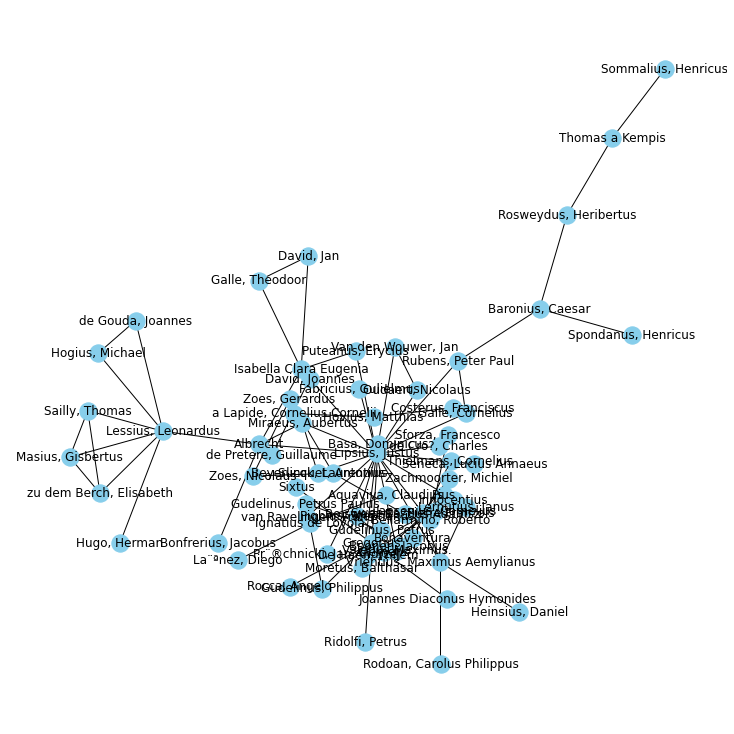

In [188]:
G = nx.from_pandas_edgelist(relation_df,
                           source = 'FROM',
                           target = 'TO',
                           edge_attr = 'VALUE',
                           create_using=nx.Graph())
plt.figure(figsize=(10,10))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, with_labels = True, node_color = 'skyblue',edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

In [189]:
net = Network(notebook = True, width = '1000px',height = '700px',bgcolor='#222222',font_color='white')

node_degree = dict(G.degree)
nx.set_node_attributes(G,node_degree,'size')


net.from_nx(G)
net.show('author.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


Since

In [371]:
# the most important person 
# degree centrality

degree_dict = nx.degree_centrality(G)
degree_dict

{'Albrecht': 0.07246376811594203,
 'Isabella Clara Eugenia': 0.07246376811594203,
 'Lipsius, Justus': 0.2898550724637681,
 'Sweerts, Pierre Fran?ois': 0.043478260869565216,
 'Seneca, Lucius Annaeus': 0.014492753623188406,
 'Puteanus, Erycius': 0.028985507246376812,
 'David, Jan': 0.028985507246376812,
 'Galle, Theodoor': 0.028985507246376812,
 'Costerus, Franciscus': 0.014492753623188406,
 'Hovius, Matthias': 0.028985507246376812,
 'Oudaert, Nicolaus': 0.028985507246376812,
 'de Cro?, Charles': 0.014492753623188406,
 'Vrientius, Maximus Aemylianus': 0.07246376811594203,
 'Galle, Cornelius': 0.028985507246376812,
 'Rubens, Peter Paul': 0.043478260869565216,
 'Baronius, Caesar': 0.043478260869565216,
 'Rosweydus, Heribertus': 0.028985507246376812,
 'de Gouda, Joannes': 0.028985507246376812,
 'Lessius, Leonardus': 0.10144927536231885,
 'Thomas a Kempis': 0.028985507246376812,
 'Sommalius, Henricus': 0.014492753623188406,
 'Van den Wouwer, Jan': 0.028985507246376812,
 'Pighius, Stephanus':

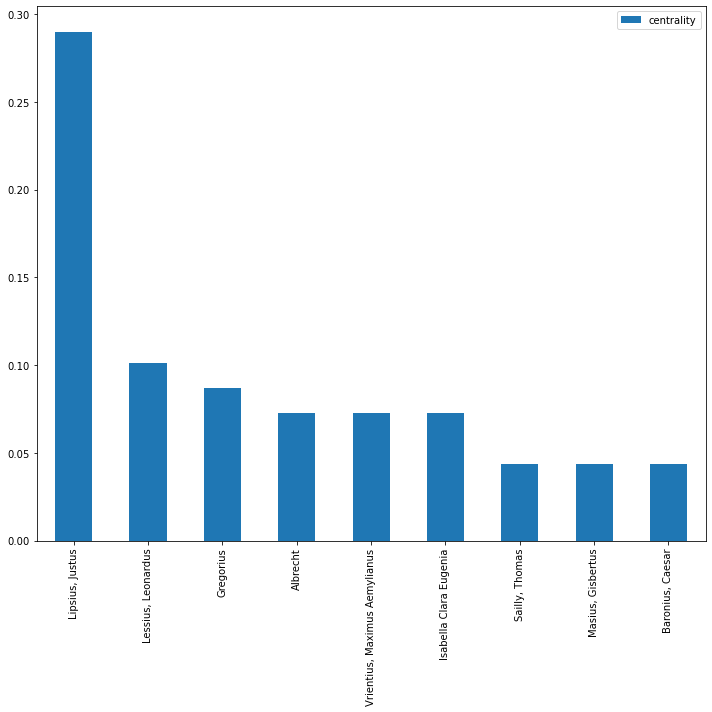

In [372]:
degree_df = pd.DataFrame.from_dict(degree_dict,orient = 'index',columns = ['centrality'])
degree_df.sort_values('centrality',ascending = False)[0:9].plot(kind = 'bar',figsize=(10, 10))
plt.tight_layout()
plt.savefig('degree.pdf',dpi = 300)

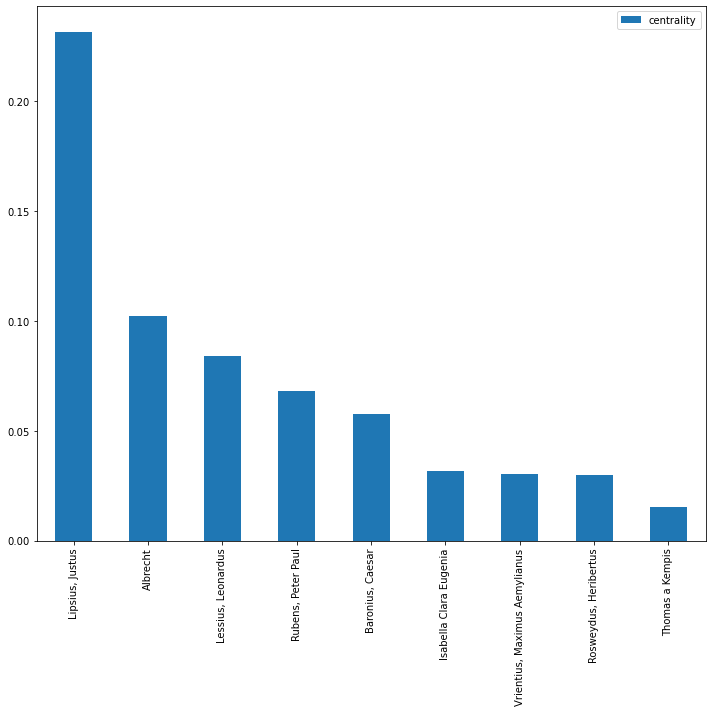

In [370]:
# Betweeness centrality
betweenness_dict = nx.betweenness_centrality(G)
betweenness_df = pd.DataFrame.from_dict(betweenness_dict,orient = 'index',columns = ['centrality'])

#Plot top 10 nodes
betweenness_df.sort_values('centrality',ascending = False)[0:9].plot(kind='bar',figsize=(10, 10))
plt.tight_layout()
plt.savefig('betweeness.pdf',dpi = 300)

## pretty much the same result

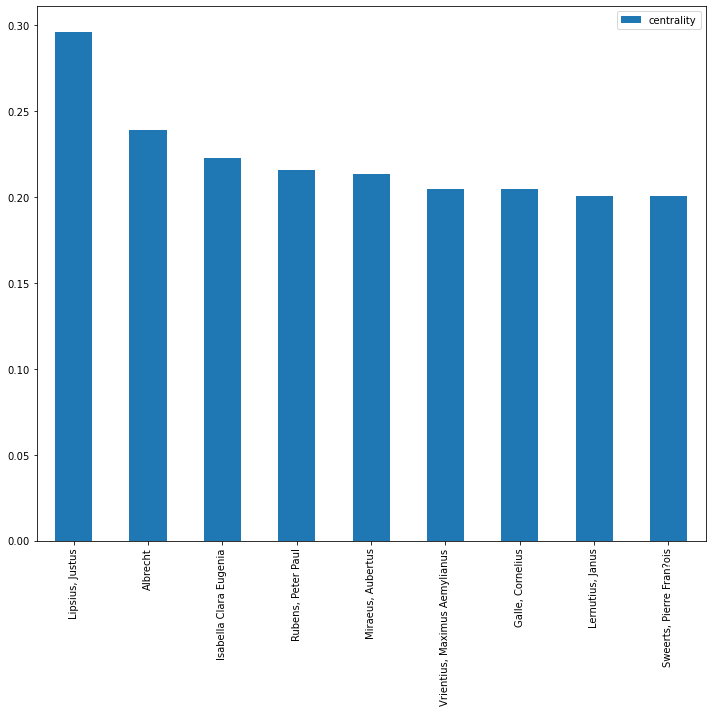

In [367]:
# Closeness centrality
closeness_dict = nx.closeness_centrality(G)
closeness_df = pd.DataFrame.from_dict(closeness_dict,orient = 'index',columns = ['centrality'])

#Plot top 10 nodes
closeness_df.sort_values('centrality',ascending = False)[0:9].plot(kind='bar',figsize=(10, 10))
plt.tight_layout()
plt.savefig('closeness.pdf',dpi = 300)


## pretty much the same result,but the gaps are smaller. this is a dense network

In [194]:
# Save centrality measures
nx.set_node_attributes(G, degree_dict,'degree_centrality')
nx.set_node_attributes(G, betweenness_dict,'betweenness_centrality')
nx.set_node_attributes(G, closeness_dict,'closeness_centrality')

In [195]:
communities = community_louvain.best_partition(G)

In [196]:
nx.set_node_attributes(G,communities,'group')

In [197]:
com_net =Network(notebook=True, width = '1000px',height = '700px',bgcolor='#222222',font_color='white')
com_net.from_nx(G)
com_net.show('author_communities.html')

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 
